In [ ]:
#| default_exp learner

These were directly copied from the corresponding notebook.

In [ ]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *
from miniai.datasets import *

from fastprogress import progress_bar,master_bar

In [ ]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.conv import *
import logging
from fastcore.test import test_close

In [ ]:
#| export
from torch.utils.data import DataLoader

In [ ]:
torch.set_printoptions(precision=2, linewidth=180, sci_mode=False)
torch.manual_seed(1103)
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
logging.disable(logging.WARNING)

# Learner

In [ ]:
x, y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)
@inplace
def transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(i)) for i in b[x]]
dst = ds.with_transform(transformi)

In [ ]:
#| export
class DataLoaders:
    def __init__(self, *dls):
        self.train, self.valid = dls[0], dls[1]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, num_workers=4):
        return cls(*[
            DataLoader(
                ds, batch_size=batch_size,
                collate_fn=collate_dict(ds), num_workers=num_workers
            ) for ds in dd.values()
        ])

In [ ]:
bs = 512
dls = DataLoaders.from_dd(dst, bs)
b = next(iter(dls.train))

In [ ]:
b[0].shape, b[1].shape

(torch.Size([512, 784]), torch.Size([512]))

In [ ]:
from miniai.training import accuracy

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func): fc.store_attr()

    def one_batch(self):
        self.xb, self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad():
            self.calc_stats()

    def calc_stats(self):
        n = self.xb.shape[0]
        self.losses.append(self.loss.item() * n)
        self.counts.append(n)
        self.accs.append(accuracy(self.preds, self.yb) * n)

    def one_epoch(self, train):
        self.model.training = train
        if train:
            dl = self.dls.valid
        else:
            dl = self.dls.train

        for self.batch_idx, self.batch in enumerate(dl):
            self.one_batch()
        count = sum(self.counts)
        stage = "train" if train else "valid"
        print(f"Epoch {self.epoch}, {stage}:  loss={sum(self.losses)/count:.4f}, accuracy={sum(self.accs)/count:.2f}")

    def fit(self, n_epochs):
        self.losses, self.counts, self.accs = [], [], []
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            self.one_epoch(False)
        

In [ ]:
b[0].shape

torch.Size([512, 784])

In [ ]:
model = nn.Sequential(nn.Linear(28*28, 50), nn.ReLU(), nn.Linear(50, 10))

In [ ]:
learn = Learner(model, dls, F.cross_entropy, 0.1, torch.optim.SGD)

In [ ]:
learn.fit(2)

Epoch 0, train:  loss=1.9508, accuracy=0.46
Epoch 0, valid:  loss=1.5761, accuracy=0.57
Epoch 1, train:  loss=1.5374, accuracy=0.58
Epoch 1, valid:  loss=1.3353, accuracy=0.61


# Metrics

In [ ]:
class Metric:
    def __init__(self): self.reset()

    def reset(self):
        self.values = []
        self.counts = []

    def add(self, inp, targ=None, n=1):
        self.values.append(self.calc(inp, targ))
        self.counts.append(n)

    @property
    def value(self):
        return (torch.tensor(self.values) * torch.tensor(self.counts)).sum() / sum(self.counts)

    def calc(self, inp, targ):
        return inp

In [ ]:
class Accuracy(Metric):
    def calc(self, inp, targ):
        return (inp == targ).float().mean()

In [ ]:
acc = Accuracy()
acc.add(torch.tensor([2, 1, 1]), torch.tensor([1, 2, 2]), 3)
print(acc.value)
acc.add(torch.tensor([1, 2, 2, 1]), torch.tensor([1, 2, 2, 1]), 4)
acc.value, 4/7

tensor(0.)


(tensor(0.57), 0.5714285714285714)

In [ ]:
loss = Metric()
loss.add(0.1, n=100)
print(loss.value)
loss.add(1.1, n=900)
print(loss.value)

tensor(0.10)
tensor(1.)


In [ ]:
#| export
from torcheval.metrics import MulticlassAccuracy, Mean

In [ ]:
print(list(filter(lambda x: x[0]!="_", dir(Mean))))

['compute', 'device', 'load_state_dict', 'merge_state', 'reset', 'state_dict', 'to', 'update']


In [ ]:
Mean.update

<function torcheval.metrics.aggregation.mean.Mean.update(self: ~TMean, input: torch.Tensor, *, weight: Union[float, int, torch.Tensor] = 1.0) -> ~TMean>

In [ ]:
acc = MulticlassAccuracy()
print(list(filter(lambda x: x[0]!="_", dir(acc))))

['average', 'compute', 'device', 'k', 'load_state_dict', 'merge_state', 'num_classes', 'num_correct', 'num_total', 'reset', 'state_dict', 'to', 'update']


In [ ]:
acc = MulticlassAccuracy()
acc.update(torch.tensor([2, 1, 1]), torch.tensor([1, 2, 2]))
print(acc.compute())
acc.update(torch.tensor([1, 2, 2]), torch.tensor([1, 2, 2]))
print(acc.compute())
acc.reset()
acc.update(torch.tensor([1, 2, 2]), torch.tensor([1, 2, 2]))
print(acc.compute())

tensor(0.)
tensor(0.50)
tensor(1.)


In [ ]:
#| export
def to_cpu(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu()
    if isinstance(x, Mapping):
        return {k: to_cpu(v) for k, v in x.items()}
    return type(x)(to_cpu(i) for i in x)

# Callbacks Learner

In [ ]:
#| export
def identity(*args):
    return (*args,)

In [ ]:
identity()

()

In [ ]:
identity(1)

(1,)

In [ ]:
identity(1, 2)

(1, 2)

In [ ]:
identity([1,2])

([1, 2],)

In [ ]:
identity([1], (2,), {3:3}, 4)

([1], (2,), {3: 3}, 4)

In [ ]:
#| export
class CancelFitException(Exception): ...
class CancelBatchException(Exception): ...
class CancelEpochException(Exception): ...

In [ ]:
#| export
class with_cbs:
    def __init__(self, nm):
        self.nm = nm
        self.before = f"before_{nm}"
        self.after = f"after_{nm}"
        self.exception = f"Cancel{nm.title()}Exception"
        self.cleanup = f"cleanup_{nm}"

    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(self.before)
                f(o, *args, **kwargs)
                o.callback(self.after)
            except globals()[self.exception]: ...
            finally: o.callback(self.cleanup)
        return _f
                

In [ ]:
#|export
class Learner:
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        if cbs is None:
            cbs = []
        fc.store_attr()
        for cb in cbs:
            cb.learn = self

    @with_cbs("batch")
    def _one_batch(self):
        self.predict()
        self.callback("after_predict")
        self.get_loss()
        self.callback("after_loss")
        if self.model.training:
            self.backward()
            self.callback("after_backward")
            self.step()
            self.callback("after_step")
            self.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        if train:
            self.dl = self.dls.train
        else:
            self.dl = self.dls.valid

        self._one_epoch()

    @with_cbs("epoch")
    def _one_epoch(self):
        for self.batch_idx, self.batch in enumerate(self.dl):
            self._one_batch()

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        if cbs is None:
            cbs = []
        for cb in cbs:
            self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.range_epochs = range(self.n_epochs)
            if lr is None:
                lr = self.lr
            if self.opt_func:
                self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs:
                self.cbs.remove(cb)

    @with_cbs("fit")
    def _fit(self, train, valid):
        for self.epoch in self.range_epochs:
            if train: self.one_epoch(True)
            if valid: self.one_epoch(False)

    def __getattr__(self, name):
        if name in ("predict", "get_loss", "backward", "step", "zero_grad"):
            return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)

    @property
    def training(self):
        return self.model.training

In [ ]:
#| export
class Callback:
    order = 0

In [ ]:
#| export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=lambda x: x.order):
        method = getattr(cb, method_nm, identity)
        if method: method(learn)

In [ ]:
#| export
class SingleBatchCB(Callback):
    def after_batch(self, learn): raise CancelFitException()

In [ ]:
#| export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp

    def predict(self, learn):
        learn.preds = learn.model(*learn.batch[:self.n_inp])

    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])

    def backward(self, learn):
        learn.loss.backward()

    def step(self, learn):
        learn.opt.step()

    def zero_grad(self, learn):
        learn.opt.zero_grad()

In [ ]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): self.device = def_device
    def before_fit(self, learn):
        if hasattr(learn.model, "to"):
            learn.model.to(self.device)
    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, self.device)

In [ ]:
type(MulticlassAccuracy()).__name__

'MulticlassAccuracy'

In [ ]:
#|export
class MetricsCB(Callback):
    def __init__(self, *args, **kwargs):
        self.metrics = kwargs
        for arg in args:
            self.metrics[type(arg).__name__] = arg

        self.loss = Mean()
        self.all = self.metrics.copy()
        self.all["loss"] = self.loss

    def log(self, to_log):
        print(to_log) 

    def before_fit(self, learn): learn.metrics = self

    def before_epoch(self, learn):
        for m in self.all.values():
            m.reset()

    def after_epoch(self, learn):
        to_log = {name: f"{m.compute():.3f}" for name, m in self.all.items()}
        to_log["epoch"] = learn.epoch
        to_log["train"] = "train" if learn.model.training else "valid"
        self.log(to_log)

    def after_batch(self, learn):
        batch = to_cpu(learn.batch) 
        x, y = batch[0], batch[1]
        while isinstance(x, tuple): x = x[0]  # TODO: this is quite bad
        preds = to_cpu(learn.preds)
        loss = to_cpu(learn.loss)
        for m in self.metrics.values():
            m.update(preds, y)
        self.loss.update(loss, weight=x.shape[0])

In [ ]:
progress_bar?

Init signature:
progress_bar(
    gen,
    total=None,
    display=True,
    leave=True,
    parent=None,
    master=None,
    comment='',
)
Docstring:      <no docstring>
File:           ~/miniforge3/envs/fastai/lib/python3.11/site-packages/fastprogress/fastprogress.py
Type:           type
Subclasses:     

In [ ]:
print(list(filter(lambda x: x[0]!='_', dir(progress_bar))))

['first_its', 'lt', 'on_interrupt', 'on_iter_begin', 'on_iter_end', 'on_update', 'update', 'update_bar', 'update_every']


In [ ]:
master_bar?

Init signature:
master_bar(
    gen,
    total=None,
    hide_graph=False,
    order=None,
    clean_on_interrupt=False,
    total_time=False,
)
Docstring:      <no docstring>
File:           ~/miniforge3/envs/fastai/lib/python3.11/site-packages/fastprogress/fastprogress.py
Type:           type
Subclasses:     

In [ ]:
print(list(filter(lambda x: x[0]!='_', dir(master_bar))))

['add_child', 'first_its', 'lt', 'names', 'on_interrupt', 'on_iter_begin', 'on_iter_end', 'on_update', 'show', 'show_imgs', 'update', 'update_bar', 'update_every', 'update_graph', 'write']


In [ ]:
master_bar.update_graph?

Signature:
master_bar.update_graph(
    self,
    graphs,
    x_bounds=None,
    y_bounds=None,
    figsize=(6, 4),
)
Docstring: <no docstring>
File:      ~/miniforge3/envs/fastai/lib/python3.11/site-packages/fastprogress/fastprogress.py
Type:      function

In [ ]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    def __init__(self, plot=False, update_rate=100): fc.store_attr()

    def before_fit(self, learn):
        learn.range_epochs = master_bar(learn.range_epochs)
        self.mb = learn.range_epochs
        self.first = True
        if hasattr(learn, "metrics"):
            learn.metrics.log = self.log
        self.losses = []
        self.val_losses = []

    def log(self, to_log):
        if self.first:
            self.first = False
            self.mb.write(list(to_log), table=True)    
        self.mb.write(list(to_log.values()), table=True)

    def before_epoch(self, learn):
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mb)

    def after_batch(self, learn):
        learn.dl.comment = f"{learn.loss:.4f}"
        if self.plot and hasattr(learn, "metrics") and learn.model.training:
            self.losses.append(to_cpu(learn.loss).item())
            if (learn.batch_idx % self.update_rate) == 0:
                self._update_graph(learn)

    def after_epoch(self, learn):
        if not learn.training:
            self.val_losses.append(learn.metrics.loss.compute())
            self._update_graph(learn)
            
    def _update_graph(self, learn):
        if self.plot:
            to_update = [[list(range(len(self.losses))), self.losses]]
            if self.val_losses:
                to_update.append([list(map(lambda step: (step+1)*len(learn.dls.train), range(len(self.val_losses)))), self.val_losses])
            self.mb.update_graph(to_update)

MulticlassAccuracy,loss,epoch,train
0.624,1.145,0,train
0.685,0.866,0,valid
0.762,0.675,1,train
0.736,0.737,1,valid


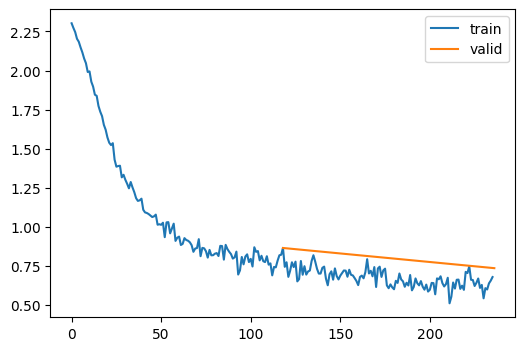

In [ ]:
model = nn.Sequential(nn.Linear(28*28, 50), nn.ReLU(), nn.Linear(50, 10))
cbs = [TrainCB(), DeviceCB(), MetricsCB(MulticlassAccuracy()), ProgressCB(True)]
learn = Learner(model, dls, F.cross_entropy, 0.1, cbs, torch.optim.SGD)
learn.fit(2)

# TrainingLearner subclass

In [ ]:
#| export
class TrainLearner(Learner):
    def predict(self):
        self.preds = self.model(self.batch[0])

    def get_loss(self):
        self.loss = self.loss_func(self.preds, self.batch[1])

    def backward(self):
        self.loss.backward()

    def step(self):
        self.opt.step()

    def zero_grad(self):
        self.opt.zero_grad()

In [ ]:
#| export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters():
                p.grad *= 0.8

MulticlassAccuracy,loss,epoch,train
0.733,0.765,0,train
0.816,0.528,0,valid


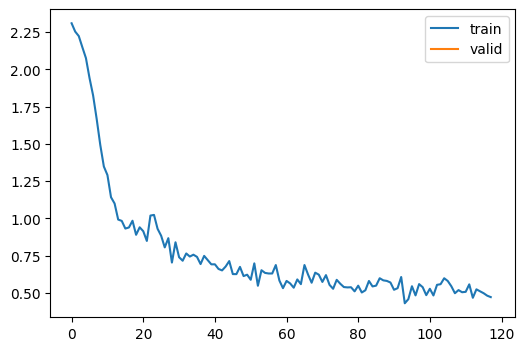

In [ ]:
model = nn.Sequential(nn.Linear(28*28, 50), nn.ReLU(), nn.Linear(50, 10))
cbs = [DeviceCB(), MetricsCB(MulticlassAccuracy()), ProgressCB(True)]
learn = MomentumLearner(model, dls, F.cross_entropy, 0.1, cbs, torch.optim.SGD)
learn.fit(1)

# LRFinderCB

In [ ]:
learn.opt.param_groups[0]["lr"]

0.1

In [ ]:
class LRFinderCB(Callback):
    def __init__(self, mult=1.3): self.mult = mult

    def before_fit(self, learn):
        self.lrs = []
        self.losses = []
        self.min = float("inf")

    def after_batch(self, learn):
        if not learn.model.training:
            raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]["lr"])
        loss = learn.loss.item()
        self.losses.append(loss)
        self.min = min(loss, self.min)
        if loss > self.min * 3:
            raise CancelFitException()
        for pg in learn.opt.param_groups:
            pg["lr"] *= self.mult

    def after_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale("log")

In [ ]:
model = nn.Sequential(nn.Linear(28*28, 50), nn.ReLU(), nn.Linear(50, 10))
cbs = [DeviceCB(), LRFinderCB(), ProgressCB()]
learn = MomentumLearner(model, dls, F.cross_entropy, 0.0001, cbs, torch.optim.SGD)
learn.fit(3)

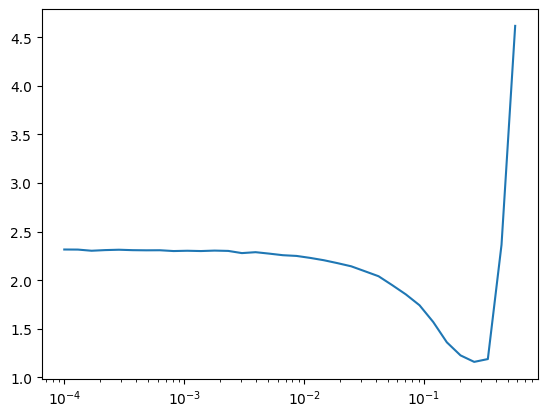

In [ ]:
cbs[1].after_fit(learn);

In [ ]:
#| export
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
ExponentialLR?

Init signature: ExponentialLR(optimizer, gamma, last_epoch=-1, verbose=False)
Docstring:     
Decays the learning rate of each parameter group by gamma every epoch.
When last_epoch=-1, sets initial lr as lr.

Args:
    optimizer (Optimizer): Wrapped optimizer.
    gamma (float): Multiplicative factor of learning rate decay.
    last_epoch (int): The index of last epoch. Default: -1.
    verbose (bool): If ``True``, prints a message to stdout for
        each update. Default: ``False``.
File:           ~/miniforge3/envs/fastai/lib/python3.11/site-packages/torch/optim/lr_scheduler.py
Type:           type
Subclasses:     

In [ ]:
#|export
class LRFinderCB(Callback):
    def __init__(self, mult=1.3, threshold=3.0): fc.store_attr()

    def before_fit(self, learn):
        self.lrs = []
        self.losses = []
        self.min = float("inf")
        self.sched = ExponentialLR(learn.opt, self.mult)

    def after_batch(self, learn):
        if not learn.model.training:
            raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]["lr"])
        loss = to_cpu(learn.loss).item()
        self.losses.append(loss)
        self.min = min(loss, self.min)
        if math.isnan(loss) or loss > self.min * self.threshold:
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale("log")

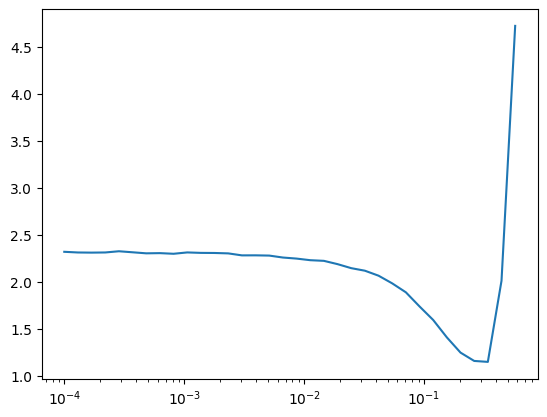

In [ ]:
model = nn.Sequential(nn.Linear(28*28, 50), nn.ReLU(), nn.Linear(50, 10))
cbs = [DeviceCB(), LRFinderCB(), ProgressCB()]
learn = MomentumLearner(model, dls, F.cross_entropy, 0.0001, cbs, torch.optim.SGD)
learn.fit(3)

In [ ]:
#| export
@fc.patch
def lr_find(self:Learner, mult=1.3, threshold=3.0, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=[LRFinderCB(mult=mult, threshold=threshold)])

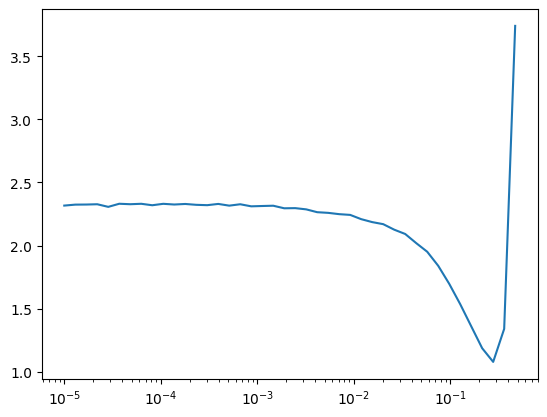

In [ ]:
model = nn.Sequential(nn.Linear(28*28, 50), nn.ReLU(), nn.Linear(50, 10))
cbs = [DeviceCB()]
learn = MomentumLearner(model, dls, F.cross_entropy, 0.0001, cbs, torch.optim.SGD)
learn.lr_find()

# Export

In [ ]:
import nbdev; nbdev.nbdev_export()